In [148]:
import dspy
import phoenix as px
import os
import json
import random
from dotenv import load_dotenv
import os
from dspy.teleprompt import BootstrapFewShotWithRandomSearch, BootstrapFewShot, LabeledFewShot,BootstrapFewShotWithOptuna, COPRO,BootstrapFinetune 
from dspy.functional import TypedPredictor
import pydantic
from typing import List, Dict

load_dotenv()

True

In [149]:
px.launch_app()
from openinference.instrumentation.dspy import DSPyInstrumentor
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.resources import Resource
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

endpoint = "http://127.0.0.1:6006/v1/traces"
resource = Resource(attributes={})
tracer_provider = trace_sdk.TracerProvider(resource=resource)
span_otlp_exporter = OTLPSpanExporter(endpoint=endpoint)
tracer_provider.add_span_processor(SimpleSpanProcessor(span_exporter=span_otlp_exporter))
trace_api.set_tracer_provider(tracer_provider=tracer_provider)
DSPyInstrumentor().instrument()

WARNI [phoenix.session.session] Existing running Phoenix instance detected! Shutting it down and starting a new instance...


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


WARNI [opentelemetry.trace] Overriding of current TracerProvider is not allowed
WARNI [opentelemetry.instrumentation.instrumentor] Attempting to instrument while already instrumented


In [150]:


# llm = dspy.OllamaLocal(model='llama3:8b-instruct-q8_0', temperature=0, max_tokens=8_000)
# dspy.settings.configure(lm=llm)
llm = dspy.OllamaLocal(model='qwen2:7b-instruct-q8_0', temperature=0, max_tokens=8_000)
# llm = dspy.OllamaLocal(model='gemma2:9b-instruct-q8_0', temperature=0, max_tokens=8_000)
# llm = dspy.OllamaLocal(model='gemma2:9b-instruct-q8_0', temperature=0, max_tokens=250)
dspy.settings.configure(lm=llm)
# gemini = dspy.Google( temperature=0)
# # Configure DeepSpeed settings
# dspy.settings.configure(lm=gemini, max_tokens=1024)

In [151]:
DATA_DIR = './data/derived_datasets/'
PROP_CLUSTERING_PATH = 'proposition_clustering.json'
SALIENCE_DETECTION_PATH = 'salience.json'

with open(os.path.join(DATA_DIR, PROP_CLUSTERING_PATH), 'r') as f:
    prop_clustering = json.load(f)

with open(os.path.join(DATA_DIR, SALIENCE_DETECTION_PATH), 'r') as f:
    salience = json.load(f)

In [152]:
PC_dataset = []

def clean_str(string :str):
    return string#.replace(r'.', r',').replace(r',,', r',').replace(r'"', r' ')

for topic in prop_clustering.keys():
    current = prop_clustering[topic]
    docSpanTexts = [item['docSpanText'] for item in  current['input_spans']]
    random.shuffle(docSpanTexts)
    spans_list = {item : index for index, item in zip(range(len(docSpanTexts)), docSpanTexts)}
    # input_spans = [clean_str(item) for item in docSpanTexts]
    input_spans = [f'<START_SPAN_{spans_list[item]}>: {clean_str(item)} <END_SPAN_{spans_list[item]}>' for item in docSpanTexts]
    clusters = []
    for cluster in prop_clustering[topic]['clusters']:
        salience_spans = {spans_list[span['docSpanText']]:int(cluster["clusterID"]) for span in cluster['spans']}
        clusters.append(salience_spans)
    flatten_cluster = str({k: v for cluster in clusters for k,v in cluster.items()})
    PC_dataset.append(dspy.Example(salience_spans=' '.join(input_spans), clusters=flatten_cluster).with_inputs('salience_spans'))

In [153]:
PC_dataset[0].salience_spans

'<START_SPAN_0>: Sierra Nevada Brewing Co., which is located in Chico, California <END_SPAN_0> <START_SPAN_1>: is our hope that homebrewers will make a batch of Resilience IPA in solidarity <END_SPAN_1> <START_SPAN_2>: Many of our employees and community members were severely impacted by this tragic event <END_SPAN_2> <START_SPAN_3>: To help raise much needed support for the recovery efforts, Sierra Nevada has created a beer called Resilience IPA. Sierra Nevada<SPAN_SEP>with all proceeds donated to the Sierra Nevada Camp Fire Relief Fund <END_SPAN_3> <START_SPAN_4>: many of Sierra Nevada\'s employees<SPAN_SEP>lost everything <END_SPAN_4> <START_SPAN_5>: In all, Resilience Butte County Proud IPA should hit the market in mid-late December more than 17,000 barrels-or 4.2 million pints <END_SPAN_5> <START_SPAN_6>: 15 percent of their employees losing homes in the fire <END_SPAN_6> <START_SPAN_7>: Sierra Nevada Founder Ken Grossman reached out to other small breweries across the country and

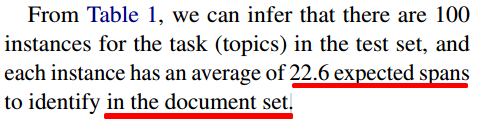

In [154]:
def calculate_num_documents(list_data):
    return len([doc for test_text in list_data.values() for doc in test_text["documents"]])

print(f'Number of Multinews (tests/ multi documents): {len(salience)}')
print(f'Number of document: {calculate_num_documents(salience)}')

Number of Multinews (tests/ multi documents): 98
Number of document: 275


In [155]:
num_topics = len([topic for topic in salience.keys()])
train_size, dev_size = int(num_topics * 0.20), int(num_topics * 0.35)
test_size = num_topics - train_size - dev_size

def train_test_split(data_dict, start_index, end_index):
    items = list(data_dict.items())
    split_data = dict(items[start_index: end_index])
    
    return split_data

train_salience = train_test_split(salience, 0, train_size)
dev_salience = train_test_split(salience, train_size, train_size + dev_size)
test_salience = train_test_split(salience, train_size + dev_size, train_size + dev_size + test_size)

train_PC = PC_dataset[:train_size]
val_PC   = PC_dataset[train_size: train_size + dev_size]
test_PC  = PC_dataset[train_size + dev_size:]

In [156]:
print(f'Train size: {len(train_salience)}')
print(f'Dev size: {len(dev_salience)}')
print(f'Test size: {len(test_salience)}')
print(f'Train documents count: {calculate_num_documents(train_salience)}')
print(f'Dev documents count: {calculate_num_documents(dev_salience)}')
print(f'Test documents count: {calculate_num_documents(test_salience)}')

Train size: 19
Dev size: 34
Test size: 45
Train documents count: 60
Dev documents count: 79
Test documents count: 136


Evaluation of Salience detection:

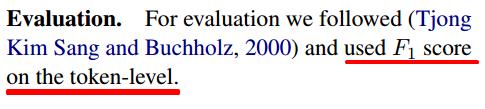

In [157]:
# class Topic(pydantic.BaseModel):
#     topic: str
#     topic_description: str

# class Topics(pydantic.BaseModel):
#     topics: List[Topic]

# class TypedQuestion2BlogOutline(dspy.Signature):
#     """Your task is to write a Weaviate blog post that will help answer the given question.\nPlease use the contexts from a web search and published Weaviate blog posts to evaluate the structure of the blog post."""
    
#     question: str = dspy.InputField()
#     blog_context: str = dspy.InputField()
#     web_context: str = dspy.InputField()
#     blog_outline: Topics = dspy.OutputField(desc="A list of topics the blog will cover. IMPORTANT!! This must follow a comma separated list of values!")

In [158]:
class DictOfSpansClustersType(pydantic.BaseModel):
    span_cluster_dict: Dict[int, int]

class PropositionClusteringSignature(dspy.Signature):
    """Please Cluster salience spans into groups. Each group should contain spans that share the same information. all the input spans should be in the output clusters"""

    # salience_spans = dspy.InputField()
    # salience_spans = dspy.InputField(format=list)
    salience_spans : str = dspy.InputField(desc='Salience spans which each span starting with <START_SPAN_IDX> and end with <END_SPAN_IDX>, each salience span can have <SPAN_SEP> which seprate bettwen subspans inside the currnet IDX span.')
    # output_length : str = dspy.InputField(desc='Fact of the expected output length')
    clusters : Dict[int, int] = dspy.OutputField(desc='A dict in the following format {<SPAN_NUMBER_IDXi>:<CLUSTER IDXi>, <SPAN_NUMBER_IDXj>:<CLUSTER IDXj>, ...}. return ONLY a dict with spans and cluster!, return ONLY a dict with spans and cluster!, return ONLY a dict with spans and cluster!, return ONLY a dict with spans and cluster!')
    # clusters : Dict[int, int] = dspy.OutputField()
    # clusters : DictOfSpansClustersType = dspy.OutputField()

In [159]:
    
# class PropositionClusteringSignature(dspy.Signature):
#     """Please Cluster salience spans into groups. Each group should contain spans that share the same information. all the input spans should be in the output clusters"""

#     # salience_spans = dspy.InputField()
#     # salience_spans = dspy.InputField(format=list)
#     salience_spans = dspy.InputField(desc='Salience spans which each span starting with <START_SPAN_IDX> and end with <END_SPAN_IDX>, each salience span can have <SPAN_SEP> which seprate bettwen subspans inside the currnet IDX span.')
#     clusters = dspy.OutputField(desc='A JSON in the following format {<SPAN_NUMBER_IDXi>:<CLUSTER IDXi>, <SPAN_NUMBER_IDXj>:<CLUSTER IDXj>, ...}. return only a JSON!')

In [160]:
class CleanDictSignature(dspy.Signature):
    """Clean the dict to be only integers. The keys and the values must be type int.

    ---

    Follow the examples:
    String dict: {"0": "cluster1","1": "cluster2","2": "cluster3","3": "cluster3","4": "cluster3","5": "cluster3","6": "cluster3","7": "cluster3","8": "cluster3","9": "cluster3","10": "cluster3","11": "cluster3","12": "cluster3","13": "cluster3","14": "cluster4"}
    Int dict:{0: 1,1: 2,2: 3,3: 3,4: 3,5: 3,6: 3,7: 3,8: 3,9: 3,10: 3,11: 3,12: 3,13: 3,14: 4}
    

     String dict: { '0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 1, '13': 1, '14': 2 }
    Int dict::{ 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 2 }
    

    String dict: "{ 'SPAN_NUMBER_0': 'CLUSTER_1', 'SPAN_NUMBER_1': 'CLUSTER_2', 'SPAN_NUMBER_2': 'CLUSTER_2', 'SPAN_NUMBER_3': 'CLUSTER_2', 'SPAN_NUMBER_4': 'CLUSTER_2', 'SPAN_NUMBER_5': 'CLUSTER_2', 'SPAN_NUMBER_6': 'CLUSTER_2', 'SPAN_NUMBER_7': 'CLUSTER_2', 'SPAN_NUMBER_8': 'CLUSTER_3', 'SPAN_NUMBER_9': 'CLUSTER_4', 'SPAN_NUMBER_10': 'CLUSTER_4' }"
    Int dict:  { 0: 1, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 3, 9: 4, 10: 4 }
    ---
    """
    

    string_dict = dspy.InputField(desc='str dict which need to be cleaned up')
    int_dict = dspy.OutputField(desc='A dict with keys as type int, and values as type int.')

In [161]:
class PropositionalClusteringCOT(dspy.Module):
    def __init__(self):
        super().__init__()

        self.generate_clusters = dspy.ChainOfThoughtWithHint(PropositionClusteringSignature, activated=False)
        self.clean_clusters = dspy.Predict(CleanDictSignature)
        # self.generate_clusters = dspy.ChainOfThought(PropositionClusteringSignature, activated=False)

    def forward(self, salience_spans):
        clusters = self.generate_clusters(salience_spans=salience_spans, hint=f'Output length should be {len(salience_spans)} spans.')
        # clusters = self.generate_clusters(salience_spans=salience_spans, output_length=f'Output length should be {len(salience_spans)} spans with there cluster idx.')
        # clusters = self.generate_clusters(salience_spans=salience_spans)
        int_clusters = self.clean_clusters(string_dict=clusters.clusters)
        # dspy.Suggest(
        #     len(int_clusters) == len(spans),
        #     f'All the spans in input must have cluster'
        # )
        pred = dspy.Prediction(clusters=int_clusters.int_dict)
        return pred

Taks:
* How to extened the ouput length.
* 

In [162]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
import numpy as np
from dspy.evaluate import Evaluate

def validate_propositional_clustering(example, pred, trace=None):
    """Validate clustering results using homogeneity, completeness, and V-measure."""
    
    true_labels = eval(example.clusters)
    predicted_labels = eval(pred.clusters)
    # print(pred.clusters)
    # list of cluster by span number if key=span_idx : value=cluster_idx if {1:0, 2:0, 0:1} then [1, 0, 0]
    true_labels_list = [true_labels[key] for key in sorted(true_labels.keys())]
    predicted_labels_list = [predicted_labels[key] for key in sorted(predicted_labels.keys())]
    # print(true_labels_list)
    # print(predicted_labels_list)
    if np.shape(true_labels_list) != np.shape(predicted_labels_list):
        print(f'Shape inst match.')
        # print(f'true_labels_list: {true_labels_list}, np.shape(true_labels_list)={np.shape(true_labels_list)}, \npredicted_labels_list:{predicted_labels_list}, np.shape(predicted_labels_list)={np.shape(predicted_labels_list)}')
        return 0
    homogeneity = homogeneity_score(true_labels_list, predicted_labels_list)
    completeness = completeness_score(true_labels_list, predicted_labels_list)
    v_measure = v_measure_score(true_labels_list, predicted_labels_list)
    
    print({
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure
    })
    return v_measure
    # return {
    #     'homogeneity': homogeneity,
    #     'completeness': completeness,
    #     'v_measure': v_measure
    # }

pc_evaluator = Evaluate(devset=val_PC, metric=validate_propositional_clustering, num_threads=3, display_progress=True, display_table=5)

In [163]:
validate_propositional_clustering(train_PC[0], dspy.Prediction(clusters=str({
    0: 1,
    1: 2,
    2: 3,
    3: 4,
    4: 5,
    5: 2,
    6: 6,
    7: 7,
    8: 8,
    9: 9,
    10: 10,
    11: 9,
    12: 11,
    13: 12,
    14: 12,
    15: 13,
    16: 14,
    17: 15,
    18: 16,
    19: 17,
    20: 18,
    21: 19,
    22: 8,
    23: 20,
    24: 21,
    25: 22,
    26: 23,
    27: 24,
    28: 25,
    29: 2,
    30: 26,
    31: 27,
    32: 28,
    33: 3,
    34: 27,
    35: 28,
    36: 29
})))
# validate_propositional_clustering(train_PC[0], dspy.Prediction(clusters={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 6, 11: 7, 12: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 1, 20: 6, 21: 17, 22: 7, 23: 8, 24: 18, 25: 19, 26: 20, 27: 21, 28: 22, 29: 23, 30: 24, 31: 25, 32: 16, 33: 26, 34: 27, 35: 28, 36: 29}))
# validate_propositional_clustering(train_PC[0], dspy.Prediction(clusters={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0}
# ))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 2, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 9, 12: 11, 13: 12, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19, 22: 8, 23: 20, 24: 21, 25: 22, 26: 23, 27: 24, 28: 25, 29: 2, 30: 26, 31: 27, 32: 28, 33: 3, 34: 27, 35: 28, 36: 29}
{'homogeneity': 0.8865078456082007, 'completeness': 0.7436322370429398, 'v_measure': 0.8088087881547094}


0.8088087881547094

In [164]:

generate_clusters = PropositionalClusteringCOT()


In [165]:
# from dspy.primitives.assertions import assert_transform_module, backtrack_handler

# baleen_with_assertions = assert_transform_module(PropositionalClusteringCOT(), backtrack_handler).activate_assertions()

# propositional_cluster_config = dict(
#     max_bootstrapped_demos=4, max_labeled_demos=4, num_candidate_programs=10, num_threads=6
# )
# # propositional_cluster_config = dict(
# #     max_bootstrapped_demos=4, max_labeled_demos=4
# # )
# telepropmpter_PC = BootstrapFewShotWithRandomSearch(metric=validate_propositional_clustering, **propositional_cluster_config)
# # telepropmpter_PC = BootstrapFewShot(metric=validate_propositional_clustering, **propositional_cluster_config)
# optimizer_propositional_clustering = telepropmpter_PC.compile(baleen_with_assertions, trainset=train_PC, valset=val_PC)

In [146]:
#Define teleprompter
teleprompter = LabeledFewShot(k=1)

# Compile!
compiled_rag = teleprompter.compile(PropositionalClusteringCOT(), trainset=train_PC)
compiled_rag(PC_dataset[51].salience_spans)

Prediction(
    clusters="{\n0: 'Cluster 1',\n1: 'Cluster 2',\n2: 'Cluster 3',\n3: 'Cluster 4'\n}"
)

In [166]:
propositional_cluster_config = dict(
    max_bootstrapped_demos=4, max_labeled_demos=4, num_candidate_programs=10, num_threads=6
)

telepropmpter_PC = BootstrapFewShotWithRandomSearch(metric=validate_propositional_clustering, **propositional_cluster_config)
optimizer_propositional_clustering = telepropmpter_PC.compile(PropositionalClusteringCOT(),teacher=PropositionalClusteringCOT(), trainset=train_PC, valset=val_PC)

  0%|          | 0/34 [00:00<?, ?it/s]

{ 0: 1, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1 }
{'homogeneity': 0.2156357729754638, 'completeness': 0.8548035084242562, 'v_measure': 0.34439359332960123}


Average Metric: 0.34439359332960123 / 1  (34.4):   3%|▎         | 1/34 [00:47<25:53, 47.09s/it]

{ 0: 'Cluster1', 1: 'Cluster1', 2: 'Cluster1', 3: 'Cluster2', 4: 'Cluster3', 5: 'Cluster3', 6: 'Cluster4', 7: 'Cluster5', 8: 'Cluster5', 9: 'Cluster6', 10: 'Cluster6', 11: 'Cluster7', 12: 'Cluster7', 13: 'Cluster8', 14: 'Cluster9', 15: 'Cluster9', 16: 'Cluster10', 17: 'Cluster11', 18: 'Cluster11', 19: 'Cluster12', 20: 'Cluster13', 21: 'Cluster14', 22: 'Cluster15' }
{'homogeneity': 0.8347477089909346, 'completeness': 0.853874207793551, 'v_measure': 0.8442026384205517}


Average Metric: 1.1885962317501528 / 2  (59.4):   6%|▌         | 2/34 [00:53<12:23, 23.24s/it] 

{
0: 'Legal Challenges and Constitutional Issues',
1: 'Political Dynamics',
2: 'Education and Affirmative Action',
3: 'Legal Predictions',
4: 'Abortion Case Outlook',
5: 'Death Penalty'
}
Shape inst match.


Average Metric: 1.1885962317501528 / 3  (39.6):   9%|▉         | 3/34 [00:55<07:04, 13.70s/it]

{ 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1 }
{'homogeneity': 0.0, 'completeness': 1.0, 'v_measure': 0.0}


Average Metric: 1.1885962317501528 / 4  (29.7):  12%|█▏        | 4/34 [01:00<05:01, 10.05s/it]

{ 0: 1, 1: 1 }
{'homogeneity': 0.0, 'completeness': 1.0, 'v_measure': 0.0}


Average Metric: 1.1885962317501528 / 5  (23.8):  15%|█▍        | 5/34 [01:00<03:11,  6.60s/it]

{ 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 3, 10: 4 }
{'homogeneity': 0.5115725397072408, 'completeness': 1.0, 'v_measure': 0.6768746140444195}


Average Metric: 1.8654708457945723 / 6  (31.1):  18%|█▊        | 6/34 [01:03<02:24,  5.16s/it]

{
  0: 'Cluster0',
  1: 'Cluster1',
  2: 'Cluster2',
  3: 'Cluster3',
  4: 'Cluster4',
  5: 'Cluster5',
  6: 'Cluster6',
  7: 'Cluster7',
  8: 'Cluster8',
  9: 'Cluster2'
}
Shape inst match.


Average Metric: 1.8654708457945723 / 7  (26.6):  21%|██        | 7/34 [01:46<07:58, 17.71s/it]

{ 1: 'A veteran who lost his genitals from a blast in Afghanistan', 2: 'The Hopkins patient received an extra experimental step, an infusion of bone marrow from his donor that research suggests may help a recipient\'s immune system better tolerate a transplant', 3: 'In addition to a large skin graft covering part of the sergeant\'s abdomen, penis and scrotum, surgeons connected three arteries, four veins and two nerves to provide blood flow and sensation to the donated tissue.', 4: 'Surgeons said that is enabling the veteran to take one anti-rejection drug instead of several', 5: 'The surgery, performed in a 14-hour procedure', 6: 'surgeons rebuilt the man\'s entire pelvic region in a 14-hour operation', 7: 'A veteran has received the world\'s most extensive penis transplant', 8: 'The scrotum transplant did not include the donor\'s testicles, meaning reproduction won\'t be possible.', 9: 'Hopkins is screening additional veterans to see if they are good candidates for this type of recon

Average Metric: 1.8654708457945723 / 8  (23.3):  24%|██▎       | 8/34 [01:56<06:31, 15.06s/it]

{ 0: 1, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 4, 9: 5, 10: 5, 11: 6, 12: 7, 13: 8, 14: 9, 15: 9, 16: 10, 17: 10 }
{'homogeneity': 0.7015111620457093, 'completeness': 0.7414084017857061, 'v_measure': 0.720908195472925}


Average Metric: 2.5863790412674974 / 9  (28.7):  26%|██▋       | 9/34 [02:00<04:55, 11.80s/it]

{ 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 9: 1, 10: 1, 11: 2, 12: 3, 13: 4, 14: 5, 15: 6, 16: 7 }
Shape inst match.


Average Metric: 2.5863790412674974 / 10  (25.9):  29%|██▉       | 10/34 [02:04<03:42,  9.27s/it]

{ 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0 }
{'homogeneity': 0.0, 'completeness': 1.0, 'v_measure': 0.0}


Average Metric: 2.5863790412674974 / 11  (23.5):  32%|███▏      | 11/34 [02:08<02:53,  7.52s/it]

{ 0: 1, 1: 1 }
{'homogeneity': 0.0, 'completeness': 1.0, 'v_measure': 0.0}


Average Metric: 2.5863790412674974 / 12  (21.6):  35%|███▌      | 12/34 [02:08<01:58,  5.39s/it]

{
0: 'Cluster 1',
1: 'Cluster 2',
2: 'Cluster 3',
3: 'Cluster 4',
4: 'Cluster 5'
}
Shape inst match.


Average Metric: 2.5863790412674974 / 13  (19.9):  38%|███▊      | 13/34 [03:06<07:24, 21.18s/it]

{
  1: "Legal and Political Involvement",
  2: "Business and Financial Connections",
  3: "Legal Proceedings",
  4: "Historical Context"
}
Shape inst match.


Average Metric: 2.5863790412674974 / 15  (17.2):  44%|████▍     | 15/34 [03:18<04:23, 13.89s/it]

{ 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1 }
{'homogeneity': 0.0, 'completeness': 1.0, 'v_measure': 0.0}


Average Metric: 2.5863790412674974 / 16  (16.2):  47%|████▋     | 16/34 [03:23<03:20, 11.14s/it]

{ 0: 1, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 6, 12: 7, 13: 8 }
{'homogeneity': 0.7259845542098009, 'completeness': 0.8994802978217412, 'v_measure': 0.8034732983841155}


Average Metric: 3.389852339651613 / 17  (19.9):  50%|█████     | 17/34 [03:26<02:29,  8.78s/it] 

{
  0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10
}
Shape inst match.


Average Metric: 3.389852339651613 / 18  (18.8):  53%|█████▎    | 18/34 [03:29<01:51,  6.99s/it]

{ 0: 'Cluster1', 1: 'Cluster2', 2: 'Cluster3', 3: 'Cluster3', 4: 'Cluster3', 5: 'Cluster3', 6: 'Cluster4', 7: 'Cluster4' }
{'homogeneity': 0.6, 'completeness': 0.8571428571428573, 'v_measure': 0.7058823529411765}


Average Metric: 4.0957346925927895 / 19  (21.6):  56%|█████▌    | 19/34 [04:13<04:34, 18.28s/it]

{ 0: 1, 1: 1, 2: 1, 3: 2, 4: 1, 5: 3, 6: 4, 7: 4, 8: 5, 9: 6, 10: 7, 11: 8, 12: 9, 13: 9, 14: 5 }
{'homogeneity': 0.7436055167065954, 'completeness': 0.9103206553141573, 'v_measure': 0.8185606742488585}


Average Metric: 4.914295366841648 / 20  (24.6):  59%|█████▉    | 20/34 [04:17<03:13, 13.80s/it] 

{
0: 'Cluster 1',
1: 'Cluster 2',
2: 'Cluster 3',
3: 'Cluster 4',
4: 'Cluster 5'
}
Shape inst match.


Average Metric: 4.914295366841648 / 22  (22.3):  65%|██████▍   | 22/34 [04:34<02:22, 11.87s/it]

{
    1: 3,
    2: 4,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    8: 8,
    9: 9,
    10: 10,
    11: 11
}
Shape inst match.


Average Metric: 4.914295366841648 / 23  (21.4):  68%|██████▊   | 23/34 [04:37<01:41,  9.24s/it]

{ 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1 }
{'homogeneity': 0.0, 'completeness': 1.0, 'v_measure': 0.0}


Average Metric: 4.914295366841648 / 24  (20.5):  71%|███████   | 24/34 [04:42<01:19,  7.99s/it]

{
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6
}
Shape inst match.


Average Metric: 4.914295366841648 / 25  (19.7):  74%|███████▎  | 25/34 [05:21<02:35, 17.27s/it]

{ 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 2 }
{'homogeneity': 0.136282290171967, 'completeness': 0.38204888752657074, 'v_measure': 0.2009005037318255}


Average Metric: 5.115195870573474 / 26  (19.7):  76%|███████▋  | 26/34 [05:23<01:41, 12.75s/it]

{ 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 3, 8: 3, 9: 3, 10: 4, 11: 4, 12: 4, 13: 5, 14: 5 }
Shape inst match.


Average Metric: 5.115195870573474 / 27  (18.9):  79%|███████▉  | 27/34 [05:27<01:09,  9.93s/it]

{
  'the birth of an island': 1,
  'volcano was mainly belching steam into the atmosphere': 1,
  'small amount of ash': 1,
  'was rising no more than about 400 meters': 1,
  'uninhabited island': 1,
  'quite an exciting site, you get to see the birth of an island': 1,
  'new island is more than one kilometer ... wide, two kilometers long': 1,
  'made of loose scoria': 1,
  'traveled by boat to within about a mile of the new island': 1,
  'has created a large new island': 2,
  'located 65 kilometres northwest of the nation\'s capital': 2,
  'will come as a relief to airlines': 2,
  'situated on the Pacific \'Ring of Fire\'' : 3,
  'volcanic eruption creates new island': 4,
  'the ministry writes': 4,
  'volcano was erupting to a height of about 400 meters': 4,
  'accompanied by some large rocks': 4,
  'other is underwater': 5
}
Shape inst match.


Average Metric: 5.115195870573474 / 28  (18.3):  82%|████████▏ | 28/34 [05:36<00:57,  9.63s/it]

{ 0: 1, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 3, 7: 7 }
{'homogeneity': 0.8333333333333333, 'completeness': 1.0, 'v_measure': 0.9090909090909091}


Average Metric: 6.024286779664383 / 29  (20.8):  85%|████████▌ | 29/34 [05:38<00:37,  7.42s/it]

{ 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 3, 9: 4, 10: 5, 11: 6, 12: 7 }
Shape inst match.


Average Metric: 6.024286779664383 / 30  (20.1):  88%|████████▊ | 30/34 [05:41<00:24,  6.07s/it]

{ 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 3, 19: 4 }
{'homogeneity': 0.471272863658183, 'completeness': 0.8991621940417953, 'v_measure': 0.618417837019492}


Average Metric: 6.642704616683875 / 31  (21.4):  91%|█████████ | 31/34 [06:21<00:48, 16.12s/it]

{
0: 'The incursion by an unmanned aircraft into Israeli airspace at the weekend',
1: 'Jamaluddin Aberoumand, deputy coordinator for Iran\'s Islamic Revolutionary Guard Corps, said the incident indicated that Israel\'s anti-missile defense system',
2: 'lacks the necessary capacity',
3: 'exposed the weakness of Israeli air defenses',
4: 'Aberoumand attributed claims the drone was made by Iran to a \'psychological operation\' by Israel but did not confirm or deny them',
5: 'goat pen in the petting corner was hit and a vet is treating the animals still alive and dealing with those that aren\'t',
6: 'The Zionist regime (Israel) has many enemies',
7: 'a drone on Saturday crossed into Israel',
8: 'over 470 rockets have been fired from Gaza but it was the first time since June that Hamas had acknowledged launching rockets',
9: 'a former chief spokesman of the military, wrote on Twitter it was an \'Iranian drone',
10: 'exploded harmlessly But',
11: 'a small unidentified aircraft crossed into s

Average Metric: 7.5671943508965684 / 32  (23.6):  94%|█████████▍| 32/34 [06:30<00:28, 14.15s/it]

{ 0: 1, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16 }
{'homogeneity': 0.9694595259800867, 'completeness': 0.940729209982832, 'v_measure': 0.9548783079027451}


Average Metric: 8.522072658799313 / 33  (25.8):  97%|█████████▋| 33/34 [06:35<00:11, 11.27s/it] 

{ 0: 1, 2: 1, 3: -1, 4: 1, 5: 1, 6: -1, 7: -1, 8: -1, 9: 1, 10: 1, 11: -1, 12: 1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: -1, 24: -1 }
{'homogeneity': 0.2308881966831951, 'completeness': 0.9166666666666664, 'v_measure': 0.3688669193705224}


  0%|          | 0/34 [00:00<?, ?it/s]

{
  "cluster1": {
    "description": "Amounts of money for the campaign allowing him to exceed his pace for 2007.",
    "example": "Mitt Romney has raised far more than $350,000 from the firm's employees."
  },
  "cluster2": {
    "description": "Individual Firm Contributions",
    "example": "Employees of Goldman Sachs gave Mr. Obama over $1 million more than donors from any other private employer in the country during the 2008 campaign."
  },
  "cluster3": {
    "description": "Comparative Analysis of Contributions",
    "example": "Mitt Romney has raised far more money than Mr. Obama this year from the firms that have been among Wall Street's top sources of donations for the two candidates."
  },
  "cluster4": {
    "description": "Detailed Breakdown by Firm",
    "example": "Employees of Goldman Sachs, who in the 2008 campaign gave Mr. Obama over $1 million more than donors from any other private employer in the country."
  },
  "cluster5": {
    "description": "Fundraising Strateg

Average Metric: 0 / 1  (0.0):   3%|▎         | 1/34 [01:42<56:23, 102.53s/it]

{
    "Location": 1,
    "Incident": 2,
    "Cause": 1,
    "Involvement": 3,
    "Community Response": 2,
    "Medical Status": 2,
    "Legal/Investigative Aspects": 2,
    "Emotional Impact": 1
}
Shape inst match.


Average Metric: 0 / 2  (0.0):   6%|▌         | 2/34 [01:45<23:26, 43.95s/it] 

{0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4', 4: 'Cluster 5'}
Shape inst match.


Average Metric: 0 / 3  (0.0):   9%|▉         | 3/34 [01:47<12:52, 24.90s/it]

{
0: 'Legal Challenges and Constitutional Issues',
1: 'Political Dynamics',
2: 'Education and Affirmative Action',
3: 'Legal Predictions',
4: 'Abortion Case Outlook',
5: 'Death Penalty'
}
Shape inst match.


Average Metric: 0 / 4  (0.0):  12%|█▏        | 4/34 [01:49<07:56, 15.88s/it]

{
1: 3,
2: 2,
3: 2,
4: 2,
5: 2,
6: 2,
7: 2
}
Shape inst match.


Average Metric: 0 / 5  (0.0):  15%|█▍        | 5/34 [01:51<05:12, 10.78s/it]

{0: 2, 1: 3}
{'homogeneity': 1.0, 'completeness': 1.0, 'v_measure': 1.0}


Average Metric: 1.0 / 6  (16.7):  18%|█▊        | 6/34 [01:52<03:26,  7.39s/it]

{0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4', 4: 'Cluster 5'}
Shape inst match.


Average Metric: 1.0 / 7  (14.3):  21%|██        | 7/34 [03:03<12:46, 28.40s/it]

{
0: 'Cluster 1',
1: 'Cluster 2',
2: 'Cluster 3',
3: 'Cluster 4'
}
Shape inst match.


Average Metric: 1.0 / 8  (12.5):  24%|██▎       | 8/34 [03:05<08:34, 19.77s/it]

{
0: 'Cluster 1',
1: 'Cluster 2',
2: 'Cluster 3',
3: 'Cluster 4',
4: 'Cluster 5'
}
Shape inst match.


Average Metric: 1.0 / 9  (11.1):  26%|██▋       | 9/34 [03:06<05:52, 14.11s/it]

{0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}
Shape inst match.


Average Metric: 1.0 / 10  (10.0):  29%|██▉       | 10/34 [03:08<04:02, 10.10s/it]

{
  1: "Cluster 1",
  2: "Cluster 2",
  3: "Cluster 3",
  4: "Cluster 4"
}
Shape inst match.


Average Metric: 1.0 / 12  (8.3):  35%|███▌      | 12/34 [03:17<02:45,  7.51s/it]

{
0: 'Cluster 1',
1: 'Cluster 2',
2: 'Cluster 3',
3: 'Cluster 4',
4: 'Cluster 5'
}
Shape inst match.


Average Metric: 1.0 / 13  (7.7):  38%|███▊      | 13/34 [04:35<10:06, 28.90s/it]

{
  1: "Legal and Political Involvement",
  2: "Business and Financial Connections",
  3: "Legal Proceedings",
  4: "Historical Context"
}
Shape inst match.


Average Metric: 1.0 / 14  (7.1):  41%|████      | 14/34 [04:37<06:54, 20.73s/it]

{1: 'Medicaid Expansion Opt-Out', 2: 'Republican Governorship Gain', 3: 'Competitive State Elections', 4: 'Republican Governor Victory Impact', 5: 'Health Care Influence', 6: 'State Governor Elections Tonight', 7: 'Republican Governorship Increase'}
Shape inst match.


Average Metric: 1.0 / 15  (6.7):  44%|████▍     | 15/34 [04:40<04:52, 15.40s/it]

{
  1: 1,
  2: 2,
  3: 3,
  4: 4
}
Shape inst match.


Average Metric: 1.0 / 16  (6.2):  47%|████▋     | 16/34 [04:41<03:21, 11.18s/it]

{
    1: "Brinkley offers support after betrayal in a courthouse setting.",
    2: "Shaw is married to Cook at age 55, possibly involving marital issues or disputes.",
    3: "Suzanne supports Peter through challenges with Christie.",
    4: "Shaw requests a new line, likely related to communication strategies or public relations.",
    5: "Shaw believes her actions were justified in taking a public stand.",
    6: "Shaw separated from Cook this year due to accusations of cheating.",
    7: "Shaw reflects on personal growth and realization following tumultuous events.",
    8: "Christie's marriage ended after discovering an affair with Cook.",
    9: "Christie was unfairly portrayed as an embittered ex-wife.",
    10: "Peter's infidelities led to his legal separation from Suzanne Shaw.",
    11: "Shaw attributes her marital issues to Christie Brinkley's alleged hatred.",
    12: "Suzanne apologizes for bad-mouthing Christie both privately and publicly.",
    13: "Shaw expresses regret 

Average Metric: 1.0 / 17  (5.9):  50%|█████     | 17/34 [04:51<03:02, 10.75s/it]

{
  0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10
}
Shape inst match.


Average Metric: 1.0 / 19  (5.3):  56%|█████▌    | 19/34 [06:22<08:06, 32.42s/it]

{
  1: "Cluster 1",
  2: "Cluster 2",
  3: "Cluster 3"
}
Shape inst match.


Average Metric: 1.0 / 20  (5.0):  59%|█████▉    | 20/34 [06:24<05:25, 23.23s/it]

{
0: 'Cluster 1',
1: 'Cluster 2',
2: 'Cluster 3',
3: 'Cluster 4',
4: 'Cluster 5'
}
Shape inst match.


Average Metric: 1.0 / 21  (4.8):  62%|██████▏   | 21/34 [06:26<03:38, 16.79s/it]

{ 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 4: 'Cluster 4', 5: 'Cluster 5', 6: 'Cluster 6' }
Shape inst match.


Average Metric: 1.0 / 22  (4.5):  65%|██████▍   | 22/34 [06:28<02:28, 12.36s/it]

{
  1: 9,
  2: 2,
  3: 16,
  4: 850000,
  5: 73700000,
  6: 16,
  7: 48
}
Shape inst match.


Average Metric: 1.0 / 23  (4.3):  68%|██████▊   | 23/34 [06:31<01:44,  9.50s/it]

{
  1: 1,
  2: 2,
  3: 3,
  4: 4
}
Shape inst match.


Average Metric: 1.0 / 24  (4.2):  71%|███████   | 24/34 [06:33<01:11,  7.19s/it]

{
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6
}
Shape inst match.


Average Metric: 1.0 / 25  (4.0):  74%|███████▎  | 25/34 [07:35<03:34, 23.80s/it]

{
0: 'Cluster 1',
1: 'Cluster 2',
2: 'Cluster 3',
3: 'Cluster 4'
}
Shape inst match.


Average Metric: 1.0 / 26  (3.8):  76%|███████▋  | 26/34 [07:36<02:16, 17.06s/it]

{0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4'}
Shape inst match.


Average Metric: 1.0 / 27  (3.7):  79%|███████▉  | 27/34 [07:38<01:26, 12.42s/it]

{
  1: "Volcanic Eruption and Island Formation",
  2: "Size and Composition",
  3: "Location and Relief for Airlines",
  4: "Ring of Fire Context",
  5: "Eruption Details"
}
Shape inst match.


Average Metric: 1.0 / 28  (3.6):  82%|████████▏ | 28/34 [07:40<00:56,  9.40s/it]

{0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}
Shape inst match.


Average Metric: 1.0 / 29  (3.4):  85%|████████▌ | 29/34 [07:42<00:35,  7.06s/it]

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
Shape inst match.


Average Metric: 1.0 / 30  (3.3):  88%|████████▊ | 30/34 [07:43<00:21,  5.37s/it]

{1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 4: 'Cluster 4', 5: 'Cluster 5'}
Shape inst match.


Average Metric: 1.0 / 31  (3.2):  91%|█████████ | 31/34 [08:33<00:55, 18.53s/it]

{0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4', 4: 'Cluster 5'}
Shape inst match.


Average Metric: 1.0 / 32  (3.1):  94%|█████████▍| 32/34 [08:34<00:27, 13.53s/it]

{0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4', 4: 'Cluster 5', 5: 'Cluster 6', 6: 'Cluster 7'}
Shape inst match.


Average Metric: 1.0 / 33  (3.0):  97%|█████████▋| 33/34 [08:37<00:10, 10.35s/it]

{
0: 1,
1: 2,
2: 2,
3: 2,
4: 2,
5: 2,
6: 2,
7: 2,
8: 3,
9: 4,
10: 4
}
Shape inst match.


  0%|          | 0/19 [00:00<?, ?it/s]

{
0: "Community Response to the Camp Fire",
1: "Scale and Impact of the Camp Fire",
2: "Sierra Nevada's Involvement",
3: "Participation from Other Breweries",
4: "Timing and Launch"
}
Shape inst match.


  5%|▌         | 1/19 [00:18<05:40, 18.93s/it]

{1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 3}
Shape inst match.


 11%|█         | 2/19 [00:40<05:44, 20.24s/it]

Tasks:
<!-- * Define the COT moudle. -->
* Define the prompt for propositional clustering.
* Update the desc output.
* Read about assertion of Json file in spesific format.
<!-- * Read about COT with hint. -->

In [ ]:
len({ 0: 1, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 9: 4, 10: 4, 11: 4, 12: 4, 13: 5, 14: 5, 15: 6, 16: 6, 17: 6, 18: 6, 19: 7, 20: 7, 21: 7, 22: 8, 23: 5, 24: 9 })

24

In [ ]:
PropositionClusteringSignature.output_fields

{'clusters': FieldInfo(annotation=str, required=True, json_schema_extra={'desc': 'A dict in the following format <SPAN_NUMBER_IDX>:<CLUSTER IDX>. Do not add anything beside the dict.', '__dspy_field_type': 'output', 'prefix': 'Clusters:'})}

In [ ]:
llm('Who are you')

["I am LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I'm not a human, but a computer program designed to simulate conversation, answer questions, and even generate text based on the input I receive.\n\nI was trained on a massive dataset of text from various sources, including books, articles, and websites. This training enables me to understand natural language processing (NLP) and generate human-like responses.\n\nMy capabilities include:\n\n1. Answering questions: I can provide information on a wide range of topics, from science and history to entertainment and culture.\n2. Generating text: I can create text based on a prompt or topic, including stories, articles, and even entire books.\n3. Translation: I can translate text from one language to another, including popular languages such as Spanish, French, German, Chinese, and many more.\n4. Summarization: I can summarize long pieces of text into shorter, more di

LLama3 have context size of 8K

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
len(tokenizer.encode(train_salience['test49']['documents'][0]))

9756